## Step 1 - Climate analysis and exploration of climate database

In [5]:
# Import dependencies

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

In [7]:
# Create engine using the `hawaii.sqlite` database file created in database_engineering steps

engine = create_engine("sqlite:///hawaii.sqlite")


In [9]:
# Declare a Base using `automap_base()`

Base = automap_base()


In [10]:
# Use the Base class to reflect the database tables

Base.prepare(engine, reflect=True)


In [11]:
# Print all of the classes mapped to the Base

Base.classes.keys()


['measurement', 'station']

In [12]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()


['measurement', 'station']

In [14]:
# Use `engine.execute` to select and display the first 10 rows from the table

engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()


[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [15]:
# Reflect Database into ORM class

Station = Base.classes.station
Measurement = Base.classes.measurement


In [16]:
# Start a session to query the database

session = Session(engine)


## Precipitation Analysis

* Query conducted to retrieve the last 12 months of precipitation data.

* `date` and `prcp` values are presented.

* Query results loaded into a Pandas DataFrame. Index set to the date column.

* Results plotted using the DataFrame `plot` method.

* Pandas is used to print the summary statistics for the precipitation data.


In [18]:
# Grabs the last date entry in the data table

last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)


('2017-08-23',)


In [19]:
# to get the last 12 months of data, last date - 365

last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)


2016-08-23


In [20]:
# query to pull the last year of precipitation data

rain = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()


In [21]:
# Load the data from the query into a dataframe

rain_df = pd.DataFrame(rain)
rain_df.head()


,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [22]:
# reset the index to the date

rain_df.set_index('date').head()


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


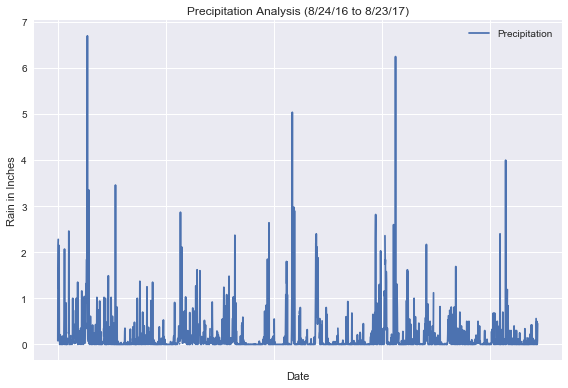

In [23]:
# plot the dataframe

rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
# Use Pandas to print the summary statistics for the precipitation data.

rain_df.describe()


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

* Query developed to calculate the total number of stations.
* Query developed to find the most active stations.
    * Listed stations and observation counts in decending order.
    * Indicated station with the highested number of observations.
* Query developed to retrieve the last 12 months of temperature observation data (tobs).
    * Filtered by stations with the highest number of observations.
    * Plotted results in a histogram with 'bns=12'.

In [27]:
# Count the number of stations in the Measurement table

locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations.".format(locations))


There are 9 stations.


In [28]:
# find the station with the most temperature observations, then list them all in descending order

busy_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
               order_by(func.count(Measurement.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")
        

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [29]:
# query to pull the last year of precipitation data for the busiest station

temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == busiest).\
    filter(Measurement.date > last_year).\
    order_by(Measurement.date).all()


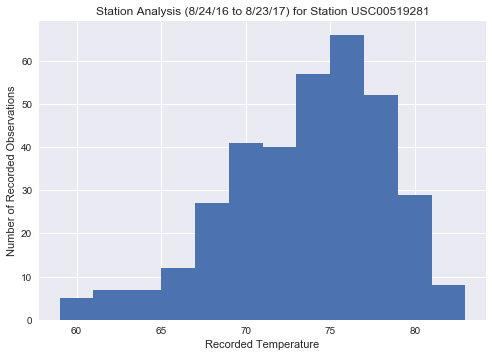

In [30]:
# plot the temperature data in a histogram with 12 bins

temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.show()


## Temperature Analysis

* Developed a function called `calc_temps` that will accept a start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.

* Used the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

* Plotted the min, avg, and max temperature from your previous query as a bar chart.

  * Used the average temperature as the bar height.

  * Used the peak-to-peak (tmax-tmin) value as the y error bar (yerr).


In [31]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
temp_range = (calc_temps('2012-02-28', '2012-03-05'))
print(temp_range)


[(62.0, 69.57142857142857, 74.0)]


In [32]:
# calculate the min/max/avg from last year that matches my trip date

trip_arrive = dt.date(2018, 4, 1)
trip_leave = dt.date(2018, 4, 15)
last_year = dt.timedelta(days=365)
temp_avg_lst_year = (calc_temps((trip_arrive-last_year), (trip_leave-last_year)))
print(temp_avg_lst_year)


[(67.0, 74.47368421052632, 82.0)]


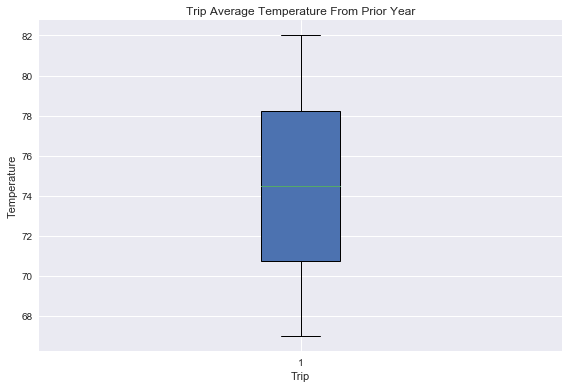

In [33]:
# plotting the data as a boxplot

fig, ax = plt.subplots()
x = range(len(temp_avg_lst_year))
ax.boxplot(temp_avg_lst_year, patch_artist=True)
ax.set_title('Trip Average Temperature From Prior Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()


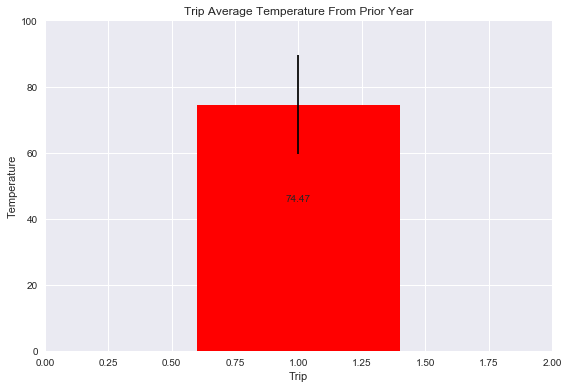

In [34]:
# plot the calculated min/max/avg from last year for the trip dates as a bar chart

p2p = temp_avg_lst_year[0][2]-temp_avg_lst_year[0][0]
avgtemp = temp_avg_lst_year[0][1]
min_temp = temp_avg_lst_year[0][0]
max_temp = temp_avg_lst_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'red', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature")
ax.set_title("Trip Average Temperature From Prior Year")

def autolabels(rects):
    for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()
plt.show()
 

## Optional Recommended Analysis


* Calculates the rainfall per weather station using the previous year's matching dates.

* Calculates the daily normals. Normals are the averages for min, avg, and max temperatures.

  * Developed a function called `daily_normals` that will calculate the daily normals for a specific date. This date string will be in the format `%m-%d`. Be sure to use all historic tobs that match that date string.

  * Created a list of dates for travel in the format `%m-%d`. Use the `daily_normals` function to calculate the normals for each date string and append the results to a list.

  * Loaded the list of daily normals into a Pandas DataFrame and set the index equal to the date.

  * Used Pandas to plot an area plot (`stacked=False`) for the daily normals.


In [35]:
# set the trip variables of arrive and leave for prior year

lst_year_arrive = trip_arrive - last_year
lst_year_leave = trip_leave - last_year
print(lst_year_arrive)
print(lst_year_leave)


2017-04-01
2017-04-15


In [37]:
# query to pull the rain fall from last year matching this years trip

vacation_data = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.date >= lst_year_arrive).\
    filter(Measurement.date <= lst_year_leave).\
    order_by(Measurement.station).all()


In [38]:
# load the query results into a dataframe and pivot on station

vacation_data_df=pd.DataFrame(vacation_data)

rain_per_station = pd.pivot_table(vacation_data_df,index=['station'],values=['prcp'], aggfunc=sum)
rain_per_station


,prcp
station,
USC00513117,1.64
USC00514830,0.90
USC00516128,5.75
USC00517948,0.00
USC00519281,4.14
USC00519397,0.27
USC00519523,0.36
